In [ ]:
# pip install transformers torch pandas scikit-learn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

path = "drive/MyDrive/HealthML/final_project_files/"
train = pd.read_csv(path + "Processed_Dataset/train_processed.csv")
val = pd.read_csv(path + "Processed_Dataset/val_processed.csv")
test = pd.read_csv(path + "Processed_Dataset/test_processed.csv")

In [ ]:
# df = pd.concat([train, val, test])
# df['ID'].nunique()

# Model Preparation

Load the ClinicalBERT model with a classification head from the Hugging Face transformers library: https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT?text=Paris+is+the+%5BMASK%5D+of+France.

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification, logging
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Suppress info messages from transformers (optional, not necessary)
logging.set_verbosity_warning()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Load Bio_ClinicalBERT with Classification Head
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=1,
    ignore_mismatched_sizes=True  # This will suppress the warnings about mismatch sizes
)

# Class for handling tokenization
class NotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Ensure all sequences are padded to the same length
            truncation=True,  # Ensure that sequences longer than model max are truncated
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float) ### SELF - changed dtype to torch.float from torch.long
        }

def create_data_loader(df, tokenizer, batch_size, max_len=512):
    ds = NotesDataset(
        texts=df.TEXT.to_numpy(),
        labels=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

batch_size = 64 ### TEMP just manually entering best batch size calculated
train_data_loader = create_data_loader(train, tokenizer, batch_size)
val_data_loader = create_data_loader(val, tokenizer, batch_size)
test_data_loader = create_data_loader(test, tokenizer, batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [5]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1.3514012837218262e-05) ### TEMP just manually entering best learning rate calculated, changed from 2e-5
total_steps = len(train_data_loader) * 10  # 10 is the number of epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    total_batches = len(data_loader)
    for step, d in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training", position=0, leave=True):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        model.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        # logits = outputs.logits
        # _, preds = torch.max(logits, dim=1)
        # preds = torch.sigmoid(logits)
        # preds = (preds > 0.5).int().squeeze()
        # correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Print progress every 200 batches ### SELF changed to 200 instead of 10
        # if (step + 1) % 200 == 0 or step == total_batches - 1:
        #     print(f'Batch {step + 1}/{total_batches}, Loss: {loss.item():.4f}')

    average_loss = np.mean(losses)
    # accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

# Hyperparameter Tuning

---



In [ ]:
def evaluate_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

In [ ]:
small_train = train.sample(frac=0.1, random_state=42)
small_val = val.sample(frac=0.1, random_state=42)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import AdamW, get_scheduler

def objective(trial):
    # Define hyperparameter search space
    learning_rate = trial.suggest_float("lr", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Create dataloaders with the suggested batch size
    train_loader = create_data_loader(small_train, tokenizer, batch_size)
    val_loader = create_data_loader(small_val, tokenizer, batch_size)

    # Initialize model and optimizer
    model = BertForSequenceClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",
        num_labels=1,   ### SELF - changed to 1
        ignore_mismatched_sizes=True
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,  # You can adjust this if needed
        num_training_steps=len(train_loader) * 10  # Assuming 10 epochs
    )

    # Train for 1 epoch to validate performance
    train_acc, train_loss = train_epoch(
        model, train_loader, optimizer, device, scheduler, len(small_train)
    )
    val_acc, val_loss = evaluate_model(
        model, val_loader, device, len(small_val)
    )

    return val_loss  # Minimize validation loss

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-12-07 20:10:12,897] A new study created in memory with name: no-name-63cccfdc-fce8-47ff-beec-adf636388cbc
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.1843


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1385



[I 2024-12-07 20:14:15,806] Trial 0 finished with value: 0.17209692165422974 and parameters: {'lr': 3.84328421973801e-05, 'batch_size': 32}. Best is trial 0 with value: 0.17209692165422974.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2151



[I 2024-12-07 20:18:12,078] Trial 1 finished with value: 0.20160158162706354 and parameters: {'lr': 1.5958357107423606e-06, 'batch_size': 64}. Best is trial 0 with value: 0.17209692165422974.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2439


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1625



[I 2024-12-07 20:22:14,726] Trial 2 finished with value: 0.16709637863749868 and parameters: {'lr': 4.92357450771844e-06, 'batch_size': 32}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2046



[I 2024-12-07 20:26:10,969] Trial 3 finished with value: 0.1961779272958134 and parameters: {'lr': 2.965002315392713e-06, 'batch_size': 64}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1966



[I 2024-12-07 20:30:07,197] Trial 4 finished with value: 0.19432805729716013 and parameters: {'lr': 2.4214813423638387e-06, 'batch_size': 64}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2795


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1559



[I 2024-12-07 20:34:09,937] Trial 5 finished with value: 0.17637190197625857 and parameters: {'lr': 3.3757787861212712e-06, 'batch_size': 32}. Best is trial 2 with value: 0.16709637863749868.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1490



[I 2024-12-07 20:38:06,226] Trial 6 finished with value: 0.1665813819913382 and parameters: {'lr': 1.3514012837218262e-05, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2052



[I 2024-12-07 20:42:02,438] Trial 7 finished with value: 0.197393065590537 and parameters: {'lr': 1.7322041230450678e-06, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.2012



[I 2024-12-07 20:45:58,690] Trial 8 finished with value: 0.1876595810558019 and parameters: {'lr': 3.536492205718577e-06, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:37,  3.24it/s]

Batch 200/712, Loss: 0.3296


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.1728


Training:  84%|████████▍ | 600/712 [03:05<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1136


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.1907



[I 2024-12-07 20:50:14,478] Trial 9 finished with value: 0.17572172968320443 and parameters: {'lr': 2.695536831520096e-06, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:37,  3.24it/s]

Batch 200/712, Loss: 0.2219


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.1431


Training:  84%|████████▍ | 600/712 [03:04<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1208


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.1989



[I 2024-12-07 20:54:30,199] Trial 10 finished with value: 0.16866206592342384 and parameters: {'lr': 1.4212587157539647e-05, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2044


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1291



[I 2024-12-07 20:58:32,896] Trial 11 finished with value: 0.16810587207587918 and parameters: {'lr': 1.0919574505607737e-05, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2034


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1474



[I 2024-12-07 21:02:35,557] Trial 12 finished with value: 0.16859008509958728 and parameters: {'lr': 6.57152752651737e-06, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.1823


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1438



[I 2024-12-07 21:06:38,277] Trial 13 finished with value: 0.17415158900568325 and parameters: {'lr': 2.64772789208653e-05, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:38,  3.24it/s]

Batch 200/712, Loss: 0.3415


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.1687


Training:  84%|████████▍ | 600/712 [03:05<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1215


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.2148



[I 2024-12-07 21:10:54,076] Trial 14 finished with value: 0.1688195075472476 and parameters: {'lr': 6.9713213599860875e-06, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1436



[I 2024-12-07 21:14:50,347] Trial 15 finished with value: 0.17196995697999268 and parameters: {'lr': 1.5993728437505313e-05, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2967


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.2153



[I 2024-12-07 21:18:53,068] Trial 16 finished with value: 0.20453939712449407 and parameters: {'lr': 1.0187645111642552e-06, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 178/178 [03:22<00:00,  1.14s/it]

Batch 178/178, Loss: 0.1832



[I 2024-12-07 21:22:49,413] Trial 17 finished with value: 0.18644848265004962 and parameters: {'lr': 5.3612688623031435e-06, 'batch_size': 64}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  56%|█████▌    | 200/356 [01:57<01:31,  1.71it/s]

Batch 200/356, Loss: 0.2531


Training: 100%|██████████| 356/356 [03:28<00:00,  1.71it/s]

Batch 356/356, Loss: 0.1403



[I 2024-12-07 21:26:52,007] Trial 18 finished with value: 0.16760986771308975 and parameters: {'lr': 1.08434805933606e-05, 'batch_size': 32}. Best is trial 6 with value: 0.1665813819913382.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:  28%|██▊       | 200/712 [01:01<02:38,  3.24it/s]

Batch 200/712, Loss: 0.2806


Training:  56%|█████▌    | 400/712 [02:03<01:36,  3.24it/s]

Batch 400/712, Loss: 0.0960


Training:  84%|████████▍ | 600/712 [03:05<00:34,  3.24it/s]

Batch 600/712, Loss: 0.1513


Training: 100%|██████████| 712/712 [03:39<00:00,  3.24it/s]

Batch 712/712, Loss: 0.2162



[I 2024-12-07 21:31:07,814] Trial 19 finished with value: 0.17131565588355904 and parameters: {'lr': 2.032275917346701e-05, 'batch_size': 16}. Best is trial 6 with value: 0.1665813819913382.


Best hyperparameters: {'lr': 1.3514012837218262e-05, 'batch_size': 64}


In [ ]:
# best_params = {'lr': 1.3514012837218262e-05, 'batch_size': 64}

# Training

In [ ]:
import os

# Define a directory to save checkpoints
checkpoint_dir = "drive/MyDrive/HealthML/final_project_files/checkpoints"  # Adjust the path
os.makedirs(checkpoint_dir, exist_ok=True) # Create directory if it doesn't exist

In [ ]:
for epoch in tqdm(range(10)):
    print(f'Epoch {epoch + 1}')
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(train)  # Make sure 'train' contains the correct number of samples
    )
    print(f'Train loss {train_loss:.4f}, Accuracy {train_acc:.4f}')

    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


Training:  11%|█         | 200/1780 [03:48<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0188


Training:  22%|██▏       | 400/1780 [07:35<31:10,  1.36s/it]

Batch 400/1780, Loss: 0.2350


Training:  34%|███▎      | 600/1780 [11:21<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0109


Training:  45%|████▍     | 800/1780 [15:08<22:08,  1.36s/it]

Batch 800/1780, Loss: 1.0056


Training:  56%|█████▌    | 1000/1780 [18:54<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0142


Training:  67%|██████▋   | 1200/1780 [22:41<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.8797


Training:  79%|███████▊  | 1400/1780 [26:27<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.2869


Training:  90%|████████▉ | 1600/1780 [30:14<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.1555


Training: 100%|██████████| 1780/1780 [33:37<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.3714
Train loss 0.2376, Accuracy 0.6837



 10%|█         | 1/10 [33:40<5:03:04, 2020.51s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_1.pth
Epoch 2


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0031


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.2512


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0012


Training:  45%|████▍     | 800/1780 [15:06<22:08,  1.36s/it]

Batch 800/1780, Loss: 0.4984


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0238


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.7503


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.2671


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.0605


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.6275
Train loss 0.1913, Accuracy 0.6837



 20%|██        | 2/10 [1:07:19<4:29:15, 2019.40s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_2.pth
Epoch 3


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0018


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.2244


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0015


Training:  45%|████▍     | 800/1780 [15:06<22:08,  1.36s/it]

Batch 800/1780, Loss: 0.4985


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0147


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.7232


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.2047


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.1431


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.7132
Train loss 0.1697, Accuracy 0.6837



 30%|███       | 3/10 [1:40:57<3:55:33, 2019.00s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_3.pth
Epoch 4


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0021


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.2682


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0010


Training:  45%|████▍     | 800/1780 [15:06<22:08,  1.36s/it]

Batch 800/1780, Loss: 0.4856


Training:  56%|█████▌    | 1000/1780 [18:53<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0164


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.7137


Training:  79%|███████▊  | 1400/1780 [26:26<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.1878


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.1627


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.6322
Train loss 0.1605, Accuracy 0.6837



 40%|████      | 4/10 [2:14:36<3:21:53, 2018.87s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_4.pth
Epoch 5


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0030


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.3087


Training:  34%|███▎      | 600/1780 [11:19<26:39,  1.36s/it]

Batch 600/1780, Loss: 0.0013


Training:  45%|████▍     | 800/1780 [15:06<22:08,  1.36s/it]

Batch 800/1780, Loss: 0.4394


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0086


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.6940


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.1384


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.2150


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.6641
Train loss 0.1508, Accuracy 0.6837



 50%|█████     | 5/10 [2:48:14<2:48:13, 2018.73s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_5.pth
Epoch 6


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0007


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.3556


Training:  34%|███▎      | 600/1780 [11:19<26:39,  1.36s/it]

Batch 600/1780, Loss: 0.0011


Training:  45%|████▍     | 800/1780 [15:06<22:09,  1.36s/it]

Batch 800/1780, Loss: 0.4923


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0089


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.6709


Training:  79%|███████▊  | 1400/1780 [26:26<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.1105


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.2466


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.6155
Train loss 0.1409, Accuracy 0.6837



 60%|██████    | 6/10 [3:21:53<2:14:34, 2018.67s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_6.pth
Epoch 7


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0005


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.3400


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0014


Training:  45%|████▍     | 800/1780 [15:06<22:08,  1.36s/it]

Batch 800/1780, Loss: 0.4869


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0076


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.6697


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.0986


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.2458


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.6142
Train loss 0.1327, Accuracy 0.6837



 70%|███████   | 7/10 [3:55:31<1:40:55, 2018.64s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_7.pth
Epoch 8


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0005


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.4221


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0011


Training:  45%|████▍     | 800/1780 [15:06<22:08,  1.36s/it]

Batch 800/1780, Loss: 0.4502


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0067


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.6548


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.1385


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.2179


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.5915
Train loss 0.1268, Accuracy 0.6837



 80%|████████  | 8/10 [4:29:10<1:07:17, 2018.60s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_8.pth
Epoch 9


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0004


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.4306


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0008


Training:  45%|████▍     | 800/1780 [15:06<22:09,  1.36s/it]

Batch 800/1780, Loss: 0.4055


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0040


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.6353


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.1457


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.3165


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.4511
Train loss 0.1227, Accuracy 0.6837



 90%|█████████ | 9/10 [5:02:48<33:38, 2018.56s/it]  

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_9.pth
Epoch 10


Training:  11%|█         | 200/1780 [03:46<35:42,  1.36s/it]

Batch 200/1780, Loss: 0.0006


Training:  22%|██▏       | 400/1780 [07:33<31:11,  1.36s/it]

Batch 400/1780, Loss: 0.4734


Training:  34%|███▎      | 600/1780 [11:19<26:40,  1.36s/it]

Batch 600/1780, Loss: 0.0006


Training:  45%|████▍     | 800/1780 [15:06<22:09,  1.36s/it]

Batch 800/1780, Loss: 0.3011


Training:  56%|█████▌    | 1000/1780 [18:52<17:37,  1.36s/it]

Batch 1000/1780, Loss: 0.0074


Training:  67%|██████▋   | 1200/1780 [22:39<13:06,  1.36s/it]

Batch 1200/1780, Loss: 0.5560


Training:  79%|███████▊  | 1400/1780 [26:25<08:35,  1.36s/it]

Batch 1400/1780, Loss: 0.2397


Training:  90%|████████▉ | 1600/1780 [30:12<04:04,  1.36s/it]

Batch 1600/1780, Loss: 0.2108


Training: 100%|██████████| 1780/1780 [33:35<00:00,  1.13s/it]

Batch 1780/1780, Loss: 0.3883
Train loss 0.1205, Accuracy 0.6837



100%|██████████| 10/10 [5:36:27<00:00, 2018.75s/it]

Checkpoint saved to drive/MyDrive/HealthML/final_project/checkpoints/epoch_10.pth


# Model Evaluation

In [6]:
# Loading model
checkpoint_path = "drive/MyDrive/HealthML/final_project/checkpoints/epoch_10.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

<ipython-input-6-c8e6a923a10c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

def eval_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).int().squeeze() # Apply sigmoid and threshold
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().detach().numpy())
            true_labels.extend(labels.cpu().detach().numpy())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return average_loss, accuracy, precision, recall, f1

average_loss, accuracy, precision, recall, f1 = eval_model(model, val_data_loader, device, len(val))

print(f"Average loss on validation set: {average_loss}")
print(f"Accuracy on validation set: {accuracy}")
print(f"Precision on validation set: {precision}")
print(f"Recall on validation set: {recall}")
print(f"F1 Score on validation set: {f1}")

Average loss on validation set: 0.1762909579208633
Accuracy on validation set: 0.4755029001604344
Precision on validation set: 0.356329905045942
Recall on validation set: 0.976091788310206
F1 Score on validation set: 0.5220729983292636


In [1]:
# # directly taken from readmission

# def vote_score(df, score, readmission_mode, output_dir):
#     df['pred_score'] = score
#     df_sort = df.sort_values(by=['ID'])
#     #score
#     temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
#     x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
#     df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

#     fpr, tpr, thresholds = roc_curve(x, temp.values)
#     auc_score = auc(fpr, tpr)

#     plt.figure(1)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     plt.show()
#     string = 'auroc_clinicalbert_'+readmission_mode+'.png'
#     plt.savefig(os.path.join(output_dir, string))

#     return fpr, tpr, df_out

In [ ]:
from sklearn.metrics import roc_curve, auc

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get predicted probabilities for class 1
            probs = torch.sigmoid(outputs.logits)

            predictions.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions for the validation set (or test set)
val_predictions, val_true_labels = get_predictions(model, small_val_data_loader, device) ### TEMP also switched to small_val_data_loader

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_true_labels, val_predictions)
roc_auc = auc(fpr, tpr)

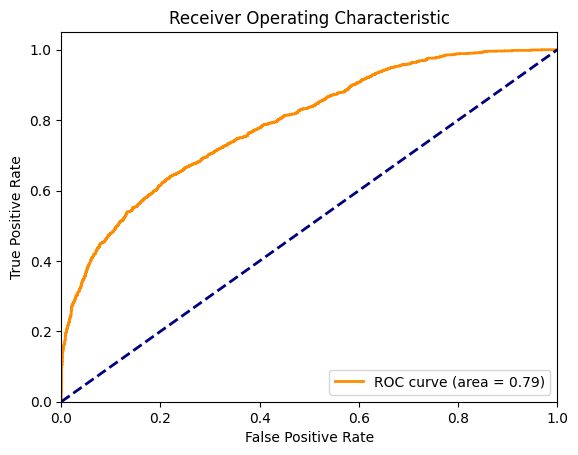

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()